# Missing Data Analysis: Habitable Planet Hunter

Issue: #57

## Objective
To analyze the extent and patterns of missing data across the 30 approved features for the Habitable Planet Hunter project. This analysis focuses on identifying:
1. The **extent** of missingness (counts and percentages).
2. The **patterns** of missing data (random vs. systematic).
3. The **relationships** between missing values across different columns.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Load the full dataset
url = 'https://raw.githubusercontent.com/opencodeiiita/habitable-planet-hunter/main/datasets/full_data.csv'

try:
    df = pd.read_csv(url)
    print("✅ Dataset loaded successfully from GitHub.")
    print(f"Shape: {df.shape}")
except Exception as e:
    print(f"Error loading data: {e}")
    try:
        df = pd.read_csv('../datasets/full_data.csv') 
        print("Dataset loaded from local file.")
    except FileNotFoundError:
        print("Dataset not found locally or via URL.")


✅ Dataset loaded successfully from GitHub.
Shape: (4048, 112)


In [15]:
# The Approved Pool of 30 Features
target_columns = [
    # Planet Physical Properties
    'P_MASS', 'P_RADIUS', 'P_DENSITY', 'P_GRAVITY', 'P_ESCAPE', 'P_TYPE',
    # Planet Orbital Parameters
    'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 'P_INCLINATION',
    'P_OMEGA', 'P_PERIASTRON', 'P_APASTRON', 'P_IMPACT_PARAMETER', 'P_HILL_SPHERE',
    # Stellar Properties
    'S_MASS', 'S_RADIUS', 'S_LUMINOSITY', 'S_TEMPERATURE', 'S_AGE',
    'S_METALLICITY', 'S_LOG_G', 'S_TYPE', 'S_MAG', 'S_DISC', 'S_MAGNETIC_FIELD',
    # System & Meta Data
    'S_SNOW_LINE', 'S_TIDAL_LOCK', 'P_DETECTION', 'P_DISTANCE'
]

# Verify all columns exist in the dataset
missing_cols = [col for col in target_columns if col not in df.columns]
if missing_cols:
    print(f"⚠️ Warning: The following columns are missing from the dataset: {missing_cols}")
else:
    print("✅ All 30 target columns found.")

# Filter dataset to only these 30 columns for analysis
df_analysis = df[target_columns].copy()
print(f"Analysis Shape: {df_analysis.shape}")


✅ All 30 target columns found.
Analysis Shape: (4048, 30)


In [16]:
# Calculate missingness
missing_count = df_analysis.isnull().sum()
missing_percent = (df_analysis.isnull().sum() / len(df_analysis)) * 100

# Create a summary dataframe
missing_summary = pd.DataFrame({
    'Missing Values': missing_count,
    'Percentage (%)': missing_percent
}).sort_values(by='Percentage (%)', ascending=False)

# Filter to show only columns with missing values > 0
missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

# Display the table
print(f"Total columns with missing data: {len(missing_summary)} / 30")
display(missing_summary.style.background_gradient(cmap='Reds'))


Total columns with missing data: 29 / 30


,Missing Values,Percentage (%)
S_DISC,4048,100.000000
S_MAGNETIC_FIELD,4048,100.000000
P_DENSITY,3342,82.559289
P_GRAVITY,3342,82.559289
P_ESCAPE,3342,82.559289
P_OMEGA,3302,81.571146
P_INCLINATION,3204,79.150198
S_TYPE,2678,66.156126
P_ECCENTRICITY,2668,65.909091
P_IMPACT_PARAMETER,2639,65.192688


## Visualizing Missingness Patterns
We use a matrix plot to observe if the missing data is distributed randomly or concentrated in specific rows.


<Figure size 1500x800 with 0 Axes>

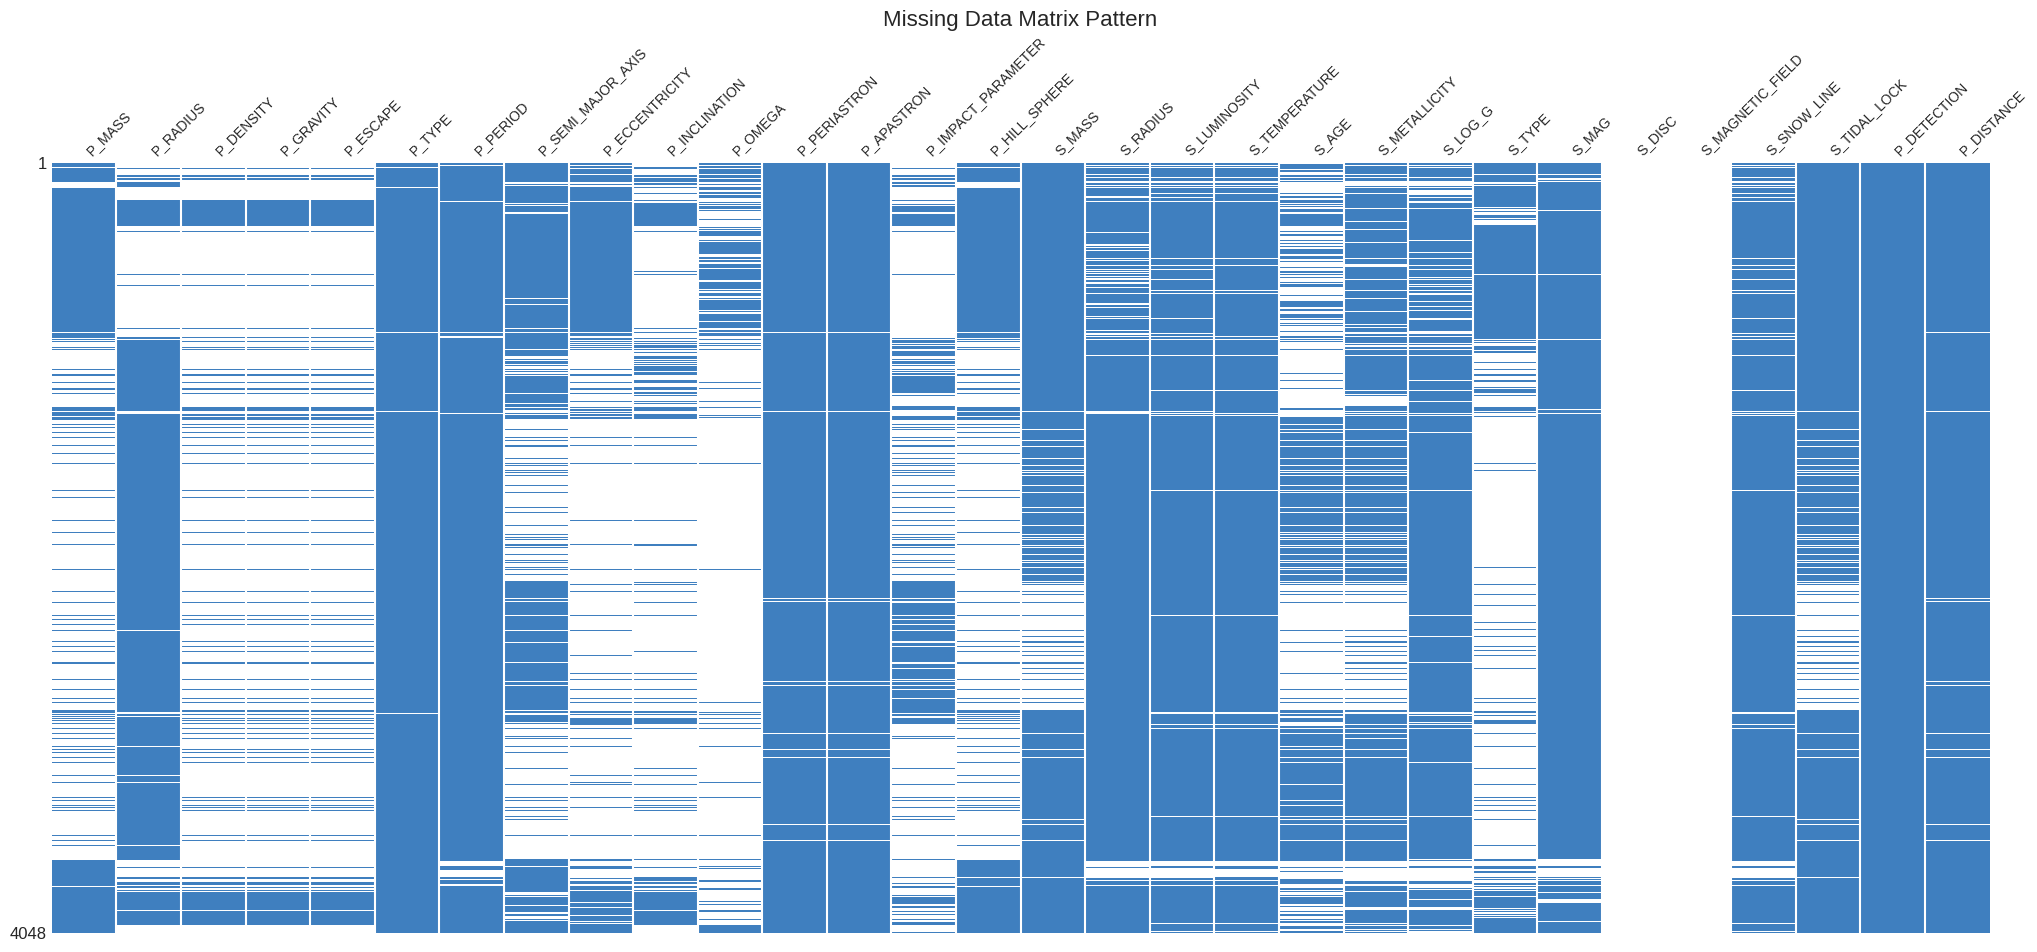

In [17]:
plt.figure(figsize=(15, 8))
msno.matrix(df_analysis, sparkline=False, fontsize=10, color=(0.25, 0.5, 0.75))
plt.title('Missing Data Matrix Pattern', fontsize=16)
plt.show()

## Relation Between Missing Values (Nullity Correlation)
This Heatmap shows the correlation of **nullity** between columns. 
- A value of **1** implies that if column A is missing, column B is also missing.
- A value of **-1** implies that if column A is missing, column B is present.
- A value of **0** implies no correlation between the missingness of the two columns.


<Figure size 1200x1000 with 0 Axes>

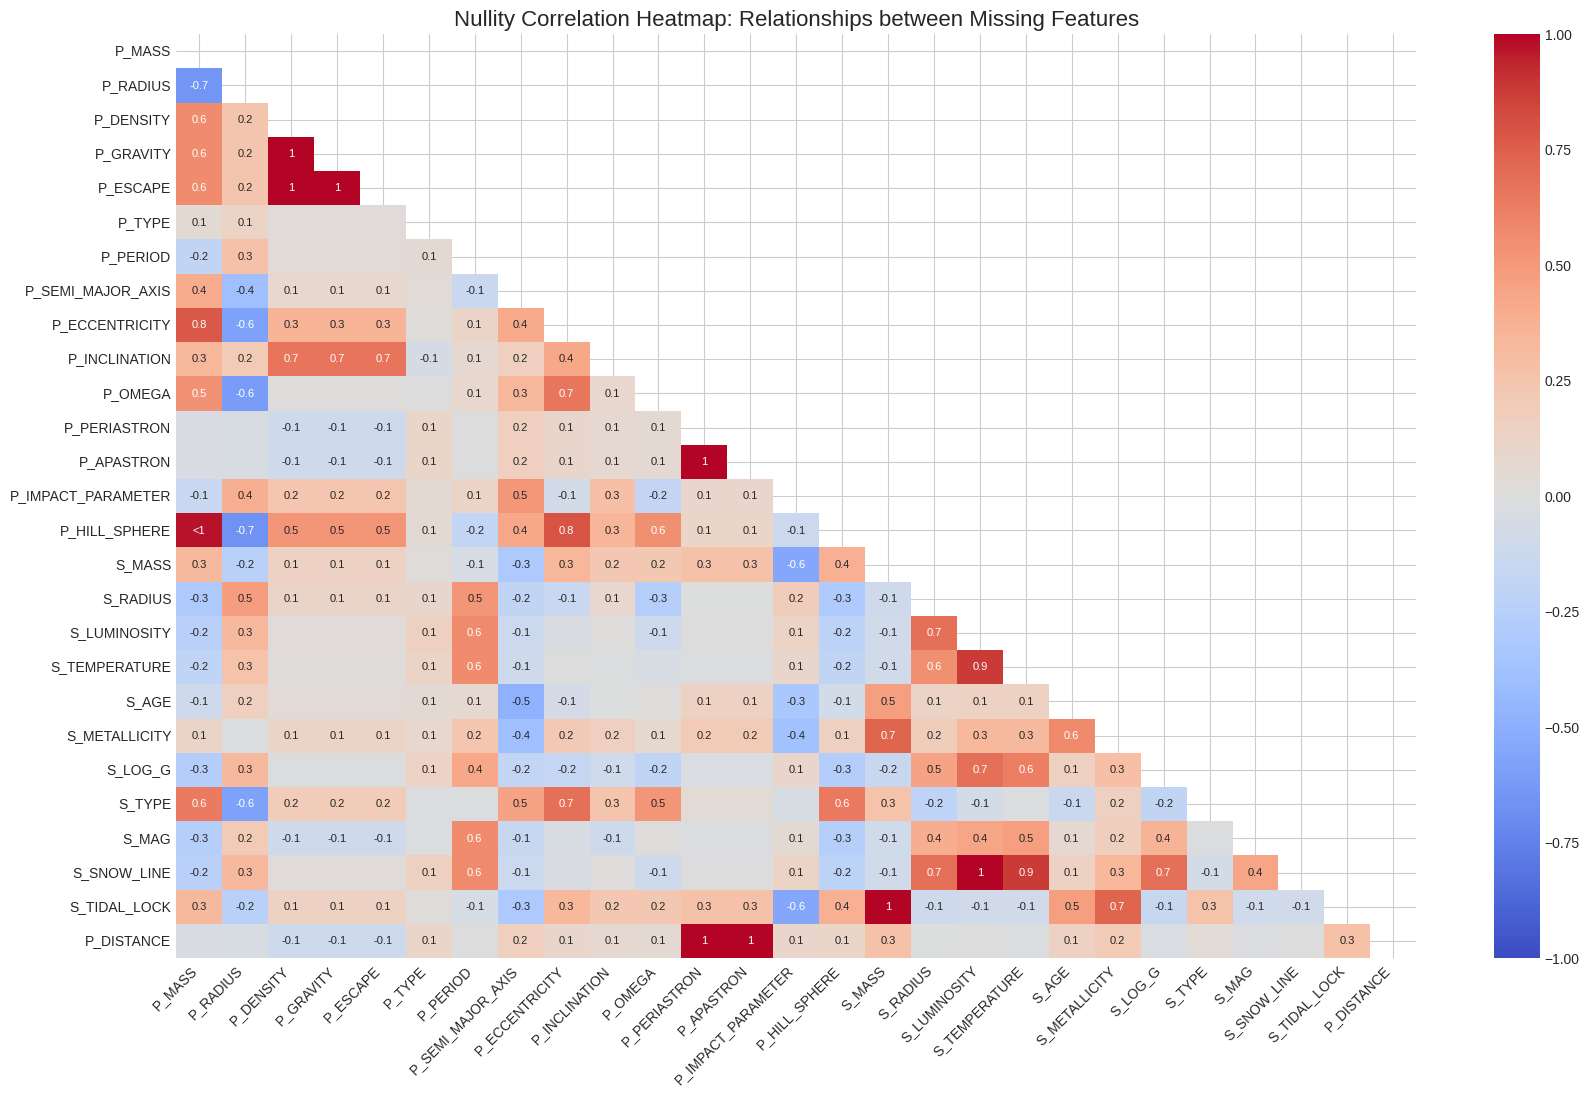

In [18]:
plt.figure(figsize=(12, 10))
msno.heatmap(df_analysis, cmap='coolwarm', fontsize=10)
plt.title('Nullity Correlation Heatmap: Relationships between Missing Features', fontsize=16)
plt.show()
